In [1]:
# dependencies
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from citipy import citipy
import numpy as np
import os
import chardet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

# establish openweather API key/url
file_name = "../../PythonScripts/BootcampExercises/API_Keys/api_keys.json"
data = json.load(open(file_name))
key = data['openweather']
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"
query_url = url + "appid=" + key + "&units=" + units + "&q="

# get olympic data files
csv_path = os.path.join("Resources", "GDP_allyears.csv")
gdp = pd.read_csv(csv_path)
csv_path = os.path.join("Resources", "country_participation.csv")
participation = pd.read_csv(csv_path)
csv_path = os.path.join("Resources", "country_codes.csv")
codes = pd.read_csv(csv_path)
csv_path = os.path.join("Resources", "country_coordinates.csv")
with open(csv_path, 'rb') as f:
    result = chardet.detect(f.read())
coordinates = pd.read_csv(csv_path, encoding=result['encoding'])

C:\Users\Diane\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# join in country codes
participation = participation.merge(codes, on='Country', how='left')

# clean/format participation data set
participation["TotalMedals"] = participation["Gold"] + participation["Silver"] + participation["Bronze"]
participation = participation.fillna(0)
participation["From"] = participation["From"].astype(int)
participation["To"] = participation["To"].astype(int)
participation["Gold"] = participation["Gold"].astype(int)
participation["Silver"] = participation["Silver"].astype(int)
participation["Bronze"] = participation["Bronze"].astype(int)
participation["Sports"] = participation["Sports"].astype(int)
participation["TotalAthletes"] = participation["Participants"].astype(int)
participation = participation.drop('Participants', 1)
participation["TotalMedals"] = participation["TotalMedals"].astype(int)
participation = participation.rename(columns={'Code':'CountryCode','Sports': 'TotalSports','Gold':'TotalGold','Silver':'TotalSilver','Bronze':'TotalBronze'})

In [3]:
# determine number of participation years
gameyears = [1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1994, 1998, 2002, 2006, 2010, 2014]
for index, row in participation.iterrows():
    counter = 0
    To = row[2]
    From = row[1]
    for year in gameyears:
        if year >= From and year <= To:
            counter = counter+1
    participation.loc[index, "TotalYears"] = counter
participation["TotalYears"] = participation["TotalYears"].astype(int)

In [4]:
# find average medals per year per country
participation["AvgMedalsPerYear"] = round(participation["TotalMedals"]/participation["TotalYears"],1)

# find average participants per year per country
participation["AvgAthletePerYear"] = round(participation["TotalAthletes"]/participation["TotalYears"],1)

# find average sports per year per country
participation["AvgSportsPerYear"] = round(participation["TotalSports"]/participation["TotalYears"],1)

# find average participants per sport per country
participation["AvgAthletePerSport"] = round(participation["TotalAthletes"]/participation["TotalSports"],1)

# join in country coordinates with participation data
coordinates = coordinates.rename(columns={'Name':'Country'})
participation = participation.merge(coordinates, on='Country', how='left')

In [5]:
# group GDP data by country, generate total of GDP yearly data points per country
country_groups = gdp.groupby("COUNTRY")
gpd_groups = pd.DataFrame(country_groups["COUNTRY"].value_counts())
gpd_groups = gpd_groups.rename(columns={'COUNTRY': 'TotalRecords'})
gpd_groups = gpd_groups.reset_index(level=0)
gpd_groups = gpd_groups.rename(columns={'COUNTRY': 'CountryCode'})
gpd_groups.index = range(len(gpd_groups))
gpd_groups.head()

# group GDP data by country, generate SUM of all GDP yearly records
country_totals = gdp.groupby("COUNTRY")
gpd_totals = pd.DataFrame(country_totals["USDperCapita"].sum())
gpd_totals = gpd_totals.rename(columns={'COUNTRY': 'TotalGDP'})
gpd_totals = gpd_totals.reset_index(level=0)
gpd_totals = gpd_totals.rename(columns={'COUNTRY': 'CountryCode'})
gpd_totals.index = range(len(gpd_groups))
gpd_totals.head()

# join in country codes, calculate average GDP
GDP = gpd_groups.merge(gpd_totals, on='CountryCode', how='left')
GDP["AvgGDP"] = round(GDP["USDperCapita"]/GDP["TotalRecords"],2)

# join in country codes, calculate average GDP, produce final table for GDP regression
GDP = GDP.merge(participation, on='CountryCode', how='left')
GDP = GDP[pd.notnull(GDP['Country'])]

In [6]:
# find reference city for each country
for index, row in participation.iterrows():
    Lat = row[15]
    Lon = row[16]
    findcity = citipy.nearest_city(Lat,Lon)
    city = findcity.city_name
    participation.loc[index, "CentralCity"] = city
    
# get temperature for central cities
for index, row in participation.iterrows():
    responseholder = []
    city = row[17]
    target_url = query_url + city.replace(" ","+")
    response = requests.get(target_url).json()
    if response["cod"] == 200:
        responseholder.append(response)
        tempresponse = [data.get("main").get("temp") for data in responseholder]
        participation.loc[index, "Temp"] = tempresponse[0]
        
# remove null temps, create final dataframe for temperature regression
temps = participation[pd.notnull(participation['Temp'])]

In [7]:
# create a flag for countries that have/not earned a medal
for index, row in participation.iterrows():
    medals = row[8]
    if medals > 0:
        participation.loc[index, "EverEarned"] = "Y"
    else:
        participation.loc[index, "EverEarned"] = "N"

In [8]:
# total Y/N flags for pie chart:
flag_totals = participation.groupby("EverEarned")
flags = pd.DataFrame(flag_totals["EverEarned"].count())
flags = flags.rename(columns={'EverEarned': 'Count'})
flags = flags.reset_index(level=0)

# determine percents:
totalcountries = flags.get_value(0, "Count") + flags.get_value(1, "Count")

# add percents
flags["PercOfTot"] = round(flags["Count"]/totalcountries,2)

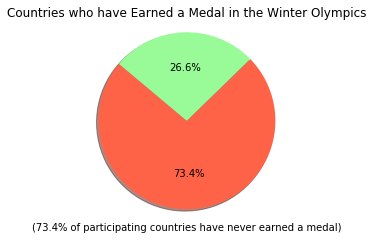

In [9]:
# winner/no wins pie chart
plt.title("Countries who have Earned a Medal in the Winter Olympics")
colors=["tomato","palegreen"]
sizes = flags['Count'].values.tolist()
plt.pie(sizes, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.axis("equal")
plt.gcf().subplots_adjust(bottom=0.20)
plt.xlabel("(73.4% of participating countries have never earned a medal)")
plt.savefig('Percent of Medal Earners.png')
plt.show()

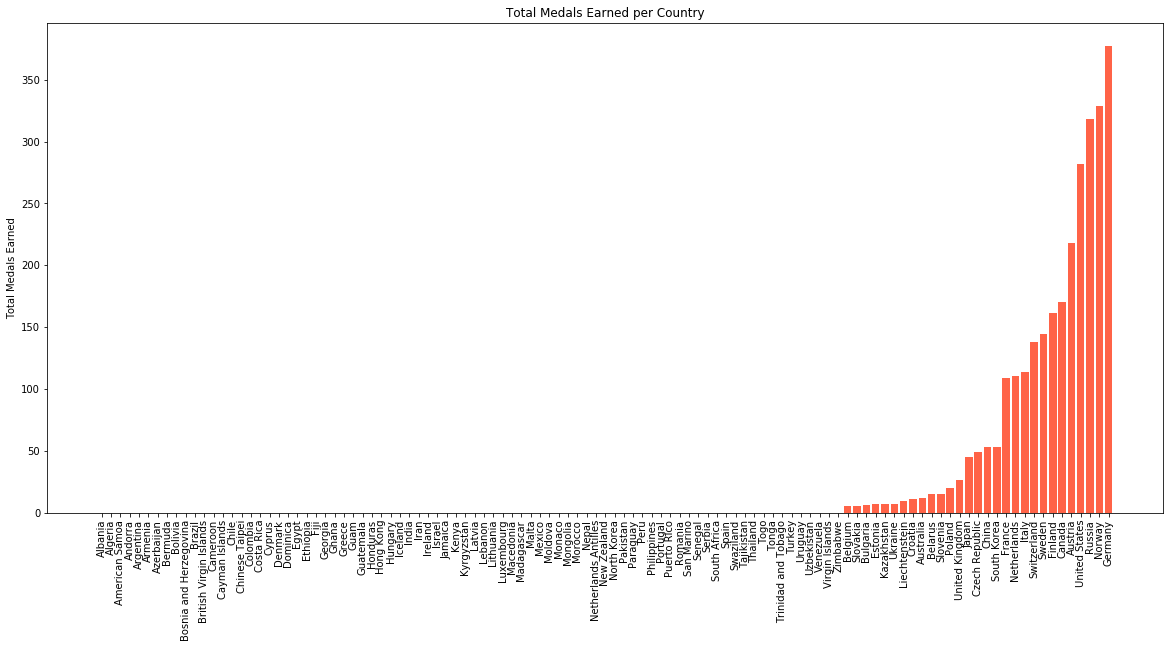

In [10]:
#create bar chart
participation = participation.sort_values(['TotalMedals', 'Country'], ascending=[True, True])
plt.figure(figsize=(20,10))
totals = participation["TotalMedals"].tolist()
countries = participation["Country"].tolist()
x_axis = np.arange(len(totals))
plt.bar(x_axis, align="edge", height = totals, color="tomato")
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(rotation=90)
plt.xticks(tick_locations, countries)
plt.gcf().subplots_adjust(bottom=0.20)
plt.ylabel("Total Medals Earned")
plt.title("Total Medals Earned per Country")
plt.savefig('Total Medals Earned.png')
plt.show()

In [11]:
##############Linear Regression: AVG Medals and AVG GDP##################

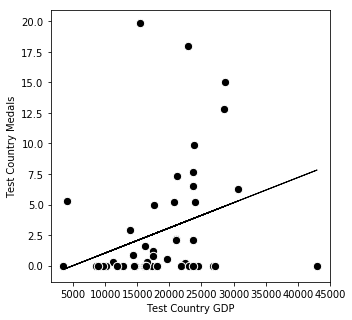

In [12]:
x = GDP['AvgGDP']
x = x.values.reshape(-1,1)
y = GDP['AvgMedalsPerYear']
y = y.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=220)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)

model = LinearRegression()
model.fit(x_train, y_train)

plt.figure(figsize=(5,5))
plt.scatter(x, y, c='black', edgecolor='white', s=70)
f = lambda x: model.coef_[0]*x + model.intercept_
plt.plot(x,f(x),color='black', lw=1)
plt.ylabel("Test Country Medals")
plt.xlabel("Test Country GDP")
plt.show()

In [13]:
model.predict(x_train)

array([[ 2.5712018 ],
       [ 1.29329012],
       [ 0.96088671],
       [ 1.98105316],
       [ 3.85568212],
       [ 2.32378254],
       [ 1.39716606],
       [ 4.86298542],
       [ 2.99997061],
       [ 2.2830599 ],
       [ 3.31132224],
       [-0.31687245],
       [ 0.98487964],
       [ 3.85940853],
       [ 4.83184264],
       [ 2.2988745 ],
       [ 3.85906639],
       [ 1.04870484],
       [ 0.80341673],
       [ 7.81892664],
       [ 1.06113722],
       [ 0.71745975],
       [ 1.9361115 ],
       [ 3.33378586],
       [ 2.69642632],
       [-0.19669344],
       [ 4.49805624],
       [ 3.69508343],
       [ 3.29690917],
       [ 2.55362498],
       [ 4.5404463 ],
       [ 3.87001068],
       [ 3.44752814],
       [ 3.22146571]])

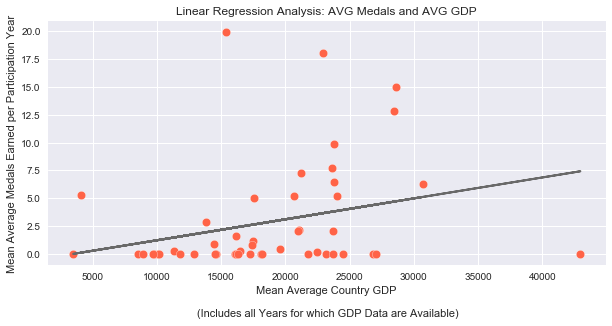

In [14]:
model = LinearRegression()
model.fit(x, y)
plt.figure(figsize=(10,5))
plt.style.use('seaborn')
plt.title("Linear Regression Analysis: AVG Medals and AVG GDP")
plt.scatter(x, y, c='tomato', edgecolor='white', s=70)
plt.plot(x, model.predict(x), color='dimgrey', lw=2)
plt.gcf().subplots_adjust(bottom=0.20)
plt.ylabel("Mean Average Medals Earned per Participation Year")
plt.xlabel("Mean Average Country GDP\n\n (Includes all Years for which GDP Data are Available)")
plt.savefig('AVG Medals and AVG GDP.png')
plt.show()

In [15]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     4.000
Date:                Thu, 08 Feb 2018   Prob (F-statistic):             0.0513
Time:                        19:01:02   Log-Likelihood:                -144.65
No. Observations:                  49   AIC:                             293.3
Df Residuals:                      47   BIC:                             297.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6283      1.862     -0.338      0.7

In [16]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

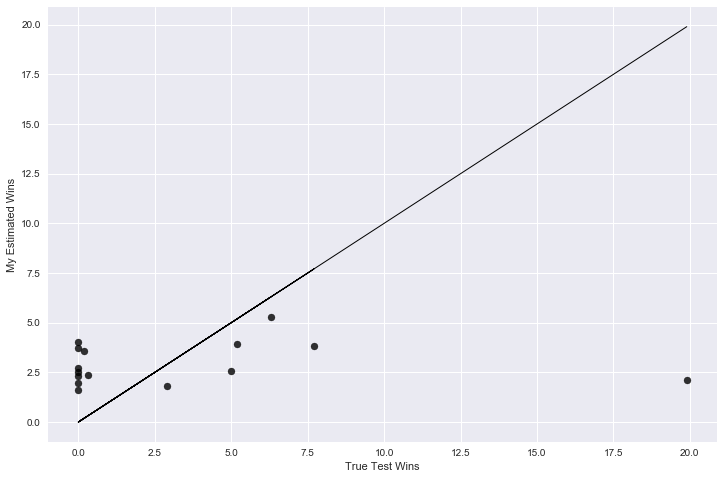

In [17]:
fig = plt.figure(figsize=(12,8))
plt.scatter(y_test, model.predict(x_test), alpha = 0.8, c='black')
plt.plot(y_test, y_test, color='black', lw=1)
plt.xlabel('True Test Wins')
plt.ylabel('My Estimated Wins')
plt.show()

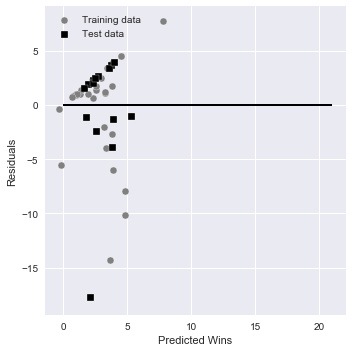

In [18]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
plt.figure(figsize=(5,5))
plt.scatter(y_train_pred,  y_train_pred - y_train,
        c='grey', marker='o', edgecolor='white',
        label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
        c='black', marker='s', edgecolor='white',
        label='Test data')
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=0, xmax=21, color='black', lw=2)
plt.tight_layout()
plt.show()

In [19]:
##############Linear Regression: AVG Medals and Latitude##################

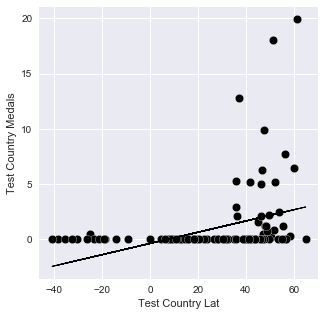

In [20]:
x = temps['Lat']
x = x.values.reshape(-1,1)
y = temps['AvgMedalsPerYear']
y = y.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=220)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)

model = LinearRegression()
model.fit(x_train, y_train)

plt.figure(figsize=(5,5))
plt.scatter(x, y, c='black', edgecolor='white', s=70)
f = lambda x: model.coef_[0]*x + model.intercept_
plt.plot(x,f(x),color='black', lw=1)
plt.ylabel("Test Country Medals")
plt.xlabel("Test Country Lat")
plt.show()

In [21]:
temps.head()

,Country,From,To,TotalSports,TotalGold,TotalSilver,TotalBronze,CountryCode,TotalMedals,TotalAthletes,TotalYears,AvgMedalsPerYear,AvgAthletePerYear,AvgSportsPerYear,AvgAthletePerSport,Lat,Lon,CentralCity,Temp
0,Albania,2006,2014,1,0,0,0,ALB,0,2,3,0.0,0.7,0.3,2.0,41.15,20.17,elbasan,46.40
1,Algeria,1992,2010,2,0,0,0,ALG,0,7,6,0.0,1.2,0.3,3.5,28.03,1.66,adrar,50.00
3,Andorra,1976,2014,4,0,0,0,AND,0,28,11,0.0,2.5,0.4,7.0,42.55,1.60,canillo,-0.93
4,Argentina,1928,2014,8,0,0,0,ARG,0,136,21,0.0,6.5,0.4,17.0,-38.42,-63.62,bahia blanca,82.01
6,Australia,1924,2014,14,5,3,4,AUS,12,240,22,0.5,10.9,0.6,17.1,-25.27,133.78,alice springs,93.20


In [22]:
model.predict(x_train)

array([[ 0.56248631],
       [ 1.68126336],
       [ 0.78035074],
       [ 0.29688467],
       [ 2.02253353],
       [ 0.57822942],
       [-1.32313294],
       [ 1.00481713],
       [ 1.42683426],
       [-0.03118159],
       [ 1.48168125],
       [ 1.52637139],
       [ 1.69142021],
       [ 0.44872958],
       [ 1.86459451],
       [ 2.61874064],
       [-0.82392375],
       [ 0.26387491],
       [ 1.46390677],
       [ 0.68843125],
       [ 2.94172848],
       [ 1.18560907],
       [ 1.74423583],
       [ 0.13792997],
       [ 0.57416668],
       [ 2.27950184],
       [ 2.53139173],
       [ 2.09972559],
       [ 1.97581202],
       [ 2.0377688 ],
       [ 1.46644598],
       [-1.08038422],
       [ 2.76703065],
       [ 0.56807257],
       [ 2.49990549],
       [ 2.45521535],
       [ 2.2073882 ],
       [ 2.24141365],
       [ 1.62133794],
       [ 1.08505625],
       [ 0.18566716],
       [ 1.87830626],
       [ 1.99053945],
       [ 2.44455066],
       [ 1.98647671],
       [ 1

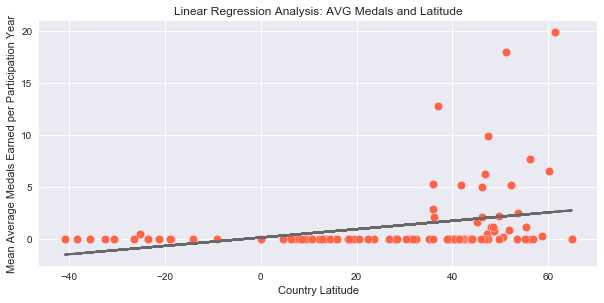

In [23]:
model = LinearRegression()
model.fit(x, y)
plt.figure(figsize=(10,5))
plt.style.use('seaborn')
plt.title("Linear Regression Analysis: AVG Medals and Latitude")
plt.scatter(x, y, c='tomato', edgecolor='white', s=70)
plt.plot(x, model.predict(x), color='dimgrey', lw=2)
plt.gcf().subplots_adjust(bottom=0.20)
plt.ylabel("Mean Average Medals Earned per Participation Year")
plt.xlabel("Country Latitude")
plt.savefig('AVG Medals and Latitude.png')
plt.show()

In [24]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
#Linear Regression Analysis: AVG Medals and Latitude

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     10.02
Date:                Thu, 08 Feb 2018   Prob (F-statistic):            0.00208
Time:                        19:01:04   Log-Likelihood:                -251.17
No. Observations:                  97   AIC:                             506.3
Df Residuals:                      95   BIC:                             511.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1436      0.483      0.297      0.7

In [25]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

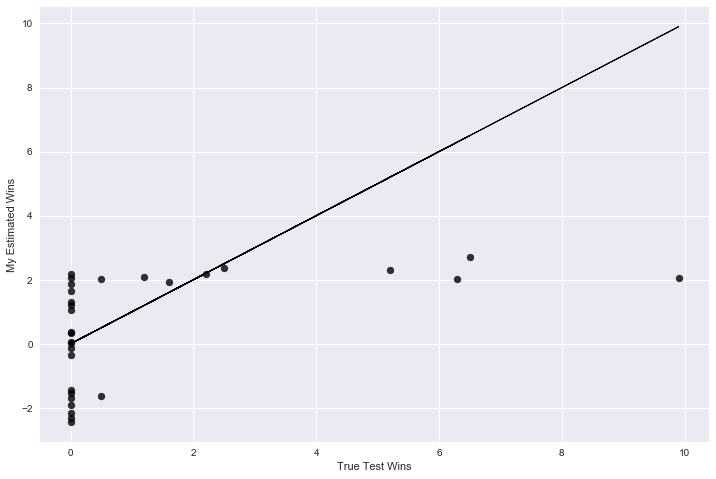

In [26]:
fig = plt.figure(figsize=(12,8))
plt.scatter(y_test, model.predict(x_test), alpha = 0.8, c='black')
plt.plot(y_test, y_test, color='black', lw=1)
plt.xlabel('True Test Wins')
plt.ylabel('My Estimated Wins')
plt.show()

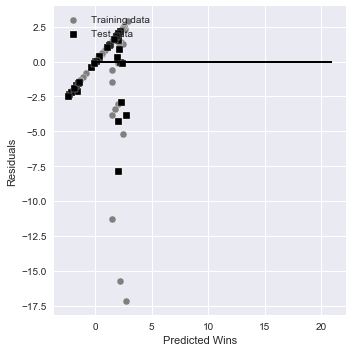

In [27]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
plt.figure(figsize=(5,5))
plt.scatter(y_train_pred,  y_train_pred - y_train,
        c='grey', marker='o', edgecolor='white',
        label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
        c='black', marker='s', edgecolor='white',
        label='Test data')
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=0, xmax=21, color='black', lw=2)
plt.tight_layout()
plt.show()

In [28]:
##############Linear Regression: AVG Medals and AVG GDP - At least one medal earned##################

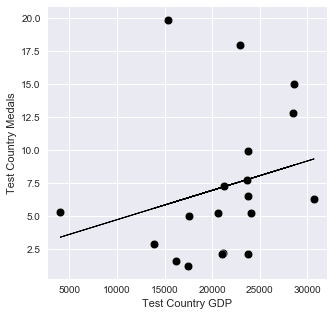

In [29]:
GDPsubset = GDP.drop(GDP[GDP.AvgMedalsPerYear < 1].index)

x = GDPsubset['AvgGDP']
x = x.values.reshape(-1,1)
y = GDPsubset['AvgMedalsPerYear']
y = y.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=220)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)

model = LinearRegression()
model.fit(x_train, y_train)

plt.figure(figsize=(5,5))
plt.scatter(x, y, c='black', edgecolor='white', s=70)
f = lambda x: model.coef_[0]*x + model.intercept_
plt.plot(x,f(x),color='black', lw=1)
plt.ylabel("Test Country Medals")
plt.xlabel("Test Country GDP")
plt.show()

In [30]:
model.predict(x_train)

array([[ 6.41001187],
       [ 7.76263322],
       [ 8.83739794],
       [ 6.394405  ],
       [ 7.79798087],
       [ 6.10011071],
       [ 7.21850206],
       [ 8.87105283],
       [ 7.17865075],
       [ 7.78652351],
       [ 7.78249651],
       [ 9.33260144],
       [ 5.92763331]])

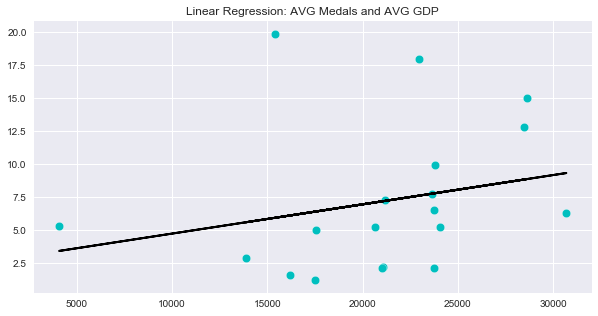

In [31]:
model = LinearRegression()
model.fit(x, y)
plt.figure(figsize=(10,5))
plt.title("Linear Regression: AVG Medals and AVG GDP")
plt.scatter(x, y, c='c', edgecolor='white', s=70)
plt.plot(x, model.predict(x), color='black', lw=2)
#plt.savefig('AVG Medals and AVG GDP.png')
plt.show()

In [32]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.063
Date:                Thu, 08 Feb 2018   Prob (F-statistic):              0.317
Time:                        19:01:06   Log-Likelihood:                -58.498
No. Observations:                  19   AIC:                             121.0
Df Residuals:                      17   BIC:                             122.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5174      4.689      0.537      0.5

C:\Users\Diane\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


In [33]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

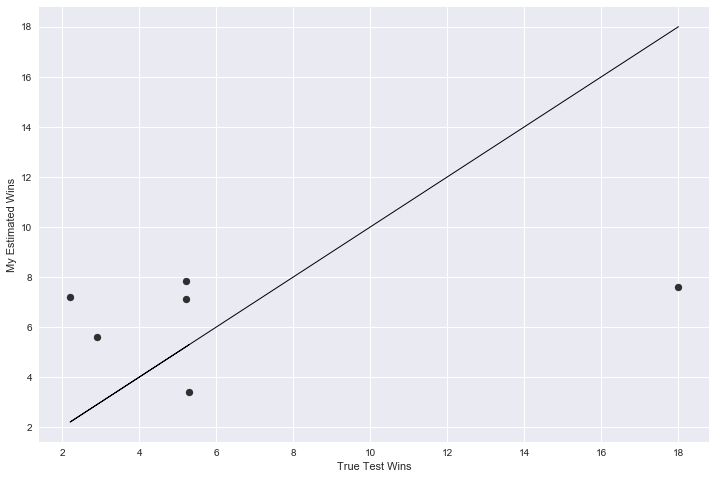

In [34]:
fig = plt.figure(figsize=(12,8))
plt.scatter(y_test, model.predict(x_test), alpha = 0.8, c='black')
plt.plot(y_test, y_test, color='black', lw=1)
plt.xlabel('True Test Wins')
plt.ylabel('My Estimated Wins')
plt.show()

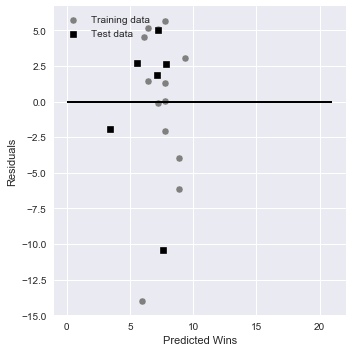

In [35]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
plt.figure(figsize=(5,5))
plt.scatter(y_train_pred,  y_train_pred - y_train,
        c='grey', marker='o', edgecolor='white',
        label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
        c='black', marker='s', edgecolor='white',
        label='Test data')
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=0, xmax=21, color='black', lw=2)
plt.tight_layout()
plt.show()